Para el proceso de segmentación se utilizarán principalmente las librerías `PIL` y `skimage`

In [1]:
%pylab inline
from skimage import color
from skimage import io
from PIL import Image
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

Populating the interactive namespace from numpy and matplotlib


Se carga la imagen, se convierte a escala de gris y se guarda como un arreglo de `numpy`.

In [2]:
file = r'/content/sample_data/f1.jpg'

img = io.imread(file)
imgGray = color.rgb2gray(img)
img = asarray(imgGray)
np.save('img', img)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

Se vuelve a cargar la imagne pero como arreglo de `numpy`.

In [4]:
file_p = r'img.npy'
img = np.load(file_p)

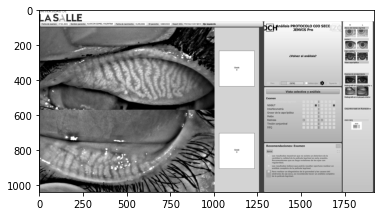

In [5]:
plt.imshow(img, cmap='gray')
plt.show()

## Identificación de id y grados(No hacer caso a esto).

from PIL import Image
imgl = Image.open(r"f1.jpg")

id_img = imgl.crop((10, 65, 1280, 90))
fig = plt.figure(figsize=(15,10))
plt.imshow(id_img, cmap='gray')
plt.show()

from pytesser import *
text = image_to_string(id_img)
print(text)

## Segmentación

Para centrarce en el párpado superior se recorta la imagen.

In [11]:
img = img[100:, 0:1005]
img_sup = img[0:470]

In [12]:
img.shape

(841, 1005)

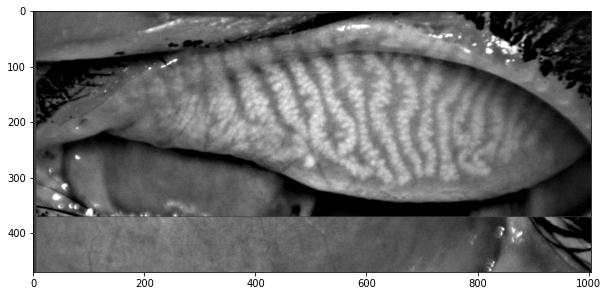

In [13]:
figure(figsize=(10,7))
plt.imshow(img_sup, cmap='gray')
plt.show()

El proceso de segmentación más simple es usar un umbral $I_t$, de manera que los pixeles cuyo valor de intensidad sea mayor a $I_t$ son asignados con el valor $1$, mientras que el resto se asignan a $0$.

In [9]:
#img_sup = img

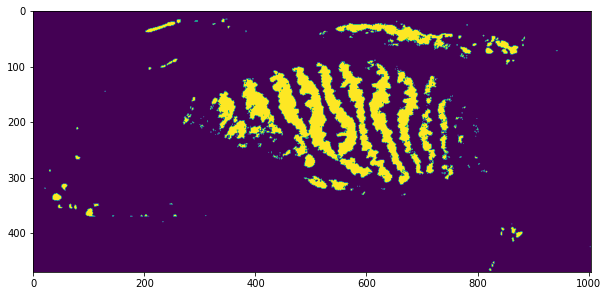

In [14]:
#Definiendo el umbral.
mask = img_sup<0.65  # 0.65
figure(figsize=(10,7))

#Por como se define el umbral, se necesita la negación de la máscara.
plt.imshow(~mask)
plt.show()

De la librería `skimage` se usa el método `label` para etiquetar cada región de pixeles(área) y de esa manera separarlas. 

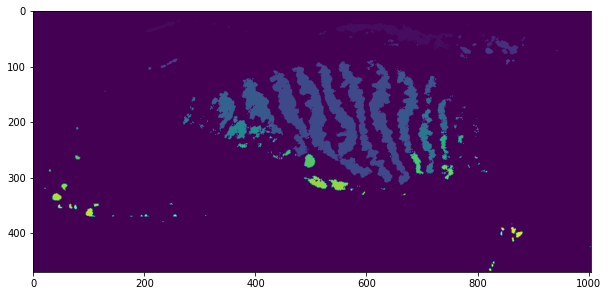

In [15]:
labeled = label(~mask)

figure(figsize=(10,7))
plt.imshow(labeled)
plt.show()

Para cada región etiquetada se pueden calcular propiedades(ver [regionprops](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)) como el área de cada región.

In [16]:
#Propiedades de las regiones.
props = regionprops(labeled)

#Áreas de cada región.
areas = [r.area for r in props]

#Índices de las áreas ordenadas de mayor a menor.
idxs = np.argsort(areas)[::-1]

Reetiquetando las primeras $20$ regiones desde la más grande hasta la más pequeña. Esto puede quitar las pequeñas manchas que aparecen en la imagen.

In [17]:
new = np.zeros_like(labeled)

for i in idxs[:20]:
    new[tuple(props[i].coords.T)] = i+1

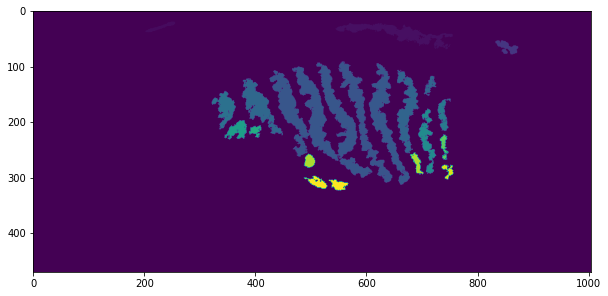

In [18]:
figure(figsize=(10,7))
plt.imshow(new)
#plt.plot(536,87, 'ro')
#plt.plot(nprops[0].coords.T[1], nprops[0].coords.T[0],'ro')
#plt.plot(yval,xval, 'rs')
plt.show()

Para las regiones en esta nueva imagen se calculan también.

In [ ]:
nprops = regionprops(new)

## Medida del ancho.

El siguiente procedimiento es para la región $3$:

* `coords` permite obtener una lista con pares de coordenadas de los puntos pertenecientes a una región, `xval` y `yval` son listas con esas coordenadas separadas por componentes.
* `backg` es una matriz de ceros con un tamaño similar al de la región.
* Para graficar la región se tiene que invertir las coordenadas.

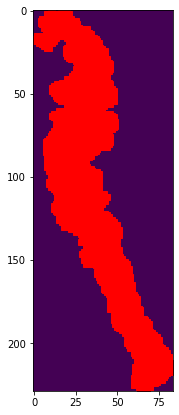

In [ ]:
kreg = 5
xval = np.array(nprops[kreg].coords.T[0])
yval = np.array(nprops[kreg].coords.T[1])

xval.min(), xval.max(), yval.min(), yval.max()

backg = np.zeros((xval.max()-xval.min()+1, yval.max()-yval.min()+1))
figure(figsize=(10,7))
plt.imshow(backg)
plt.plot(yval-yval.min(),xval-xval.min(), 'rs')
#xval-xval.min()

(0.0, 10.0)

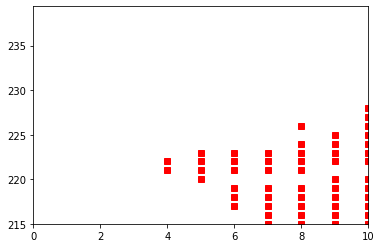

In [ ]:
#Acercamiento a los pixeles superiores de la región.
nprops[kreg].coords
plt.plot(yval-yval.min(),xval[::-1]-xval.min(), 'rs')
plt.ylim(215,)
plt.xlim(0,10)

Para obtener una matriz normal de pixeles de la región es necesario intercambiar las coordenadas e invertir el orden de las `xval`. Esto crea la matriz `b` y su transpuesta.

In [ ]:
truex = yval-yval.min()
truey = xval[::-1]-xval.min()
b = np.array([truex, truey])
trueb = b.T
trueb

array([[ 10, 228],
       [ 11, 228],
       [ 17, 228],
       ...,
       [ 66,   0],
       [ 67,   0],
       [ 68,   0]])

Para cada fila componiendo a la región se calcula el número de píxeles como la resta entre la posición del pixel más derecho y la posición del pixel más derecho.

In [ ]:
widths = np.zeros(len(np.unique(b[1])))
#Para cada fila...
for unirow in np.unique(b[1]):
    #Se obtiene las posiciones de los pixeles en una fila.
    xwidth = [item[0] for item in trueb if item[1] == unirow]
    #Se calcula el ancho de cada fila como le resta antes mencionada.
    widths[unirow] = max(xwidth)-min(xwidth)+1
widths

array([ 6.,  4., 10., 11., 12., 13., 12., 17., 17., 17., 18., 21., 25.,
       18., 22., 24., 23., 21., 18., 21., 20., 19., 18., 17., 15., 13.,
       12., 12., 21., 22., 24., 25., 26., 26., 26., 25., 17., 20., 17.,
       17., 18., 19., 20., 21., 17., 26., 20., 18., 18., 18., 19., 18.,
       18., 18., 19., 19., 16., 14., 13., 15., 16., 15., 13., 13., 13.,
       15., 14., 17., 14., 13., 12., 11., 13., 12., 10.,  8.,  9., 12.,
       12., 13., 14., 15., 15., 14., 15., 11., 14., 13., 13., 15., 16.,
       16., 16., 15., 14., 12., 12., 13., 10., 14., 15., 17., 17., 13.,
       12., 17., 10.,  9., 15.,  7.,  5.,  8., 15., 11., 14., 25., 11.,
       26., 11., 25., 13., 26., 13., 26., 16., 14., 25., 15., 26., 12.,
        9., 27.,  9., 12., 24., 23., 15., 26., 14., 25., 25., 11., 11.,
       26., 14., 27., 28., 18., 26., 26., 27., 18., 27., 26., 17., 19.,
       14., 17., 17., 33., 33., 22., 24., 29., 28., 30., 21., 32., 15.,
       35., 17., 32., 15., 32.,  7.,  6.,  6., 35., 21., 32., 32

file = [item[0] for item in trueb if item[1]==217]
max(file)-min(file)

Para aplicarlo a todas las regiones se define una función con el procedimiento anterior.

In [ ]:
def ancho(regprops):
    l = len(regprops)
    regwidths = []
    for i in range(l):
        xval = np.array(regprops[i].coords.T[0])
        yval = np.array(regprops[i].coords.T[1])
        b = np.array([yval-yval.min(), xval[::-1]-xval.min()])
        
        widths = np.zeros(len(np.unique(b[1])))
        for unirow in np.unique(b[1]):
            xwidth = [item[0] for item in b.T if item[1] == unirow]
            widths[unirow] = max(xwidth)-min(xwidth)+1
        regwidths.append( widths)
    
    return regwidths

In [ ]:
kal = np.array(ancho(nprops)[3])

In [ ]:
(widths-kal==0).all()

True

Este procedimiento puede ser útil, podría refinarse de dos formas:
* Después de quitar las regiones segmentadas más pequeñas, aún es necesario retirar las regiones grandes que no son de interés, probablemente de forma manual.
* Para obtener las longitudes de las glándulas también se puede adaptar el procedimiento.

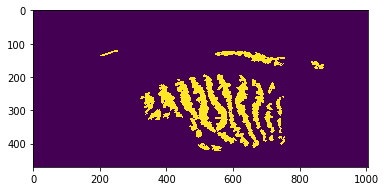

In [ ]:
plt.imshow(new>0)

In [ ]:
kal

array([ 5.,  3.,  9., 10., 11., 12., 11., 16., 16., 16., 17., 20., 24.,
       17., 21., 23., 22., 20., 17., 20., 19., 18., 17., 16., 14., 12.,
       11., 11., 20., 21., 23., 24., 25., 25., 25., 24., 16., 19., 16.,
       16., 17., 18., 19., 20., 16., 25., 19., 17., 17., 17., 18., 17.,
       17., 17., 18., 18., 15., 13., 12., 14., 15., 14., 12., 12., 12.,
       14., 13., 16., 13., 12., 11., 10., 12., 11.,  9.,  7.,  8., 11.,
       11., 12., 13., 14., 14., 13., 14., 10., 13., 12., 12., 14., 15.,
       15., 15., 14., 13., 11., 11., 12.,  9., 13., 14., 16., 16., 12.,
       11., 16.,  9.,  8., 14.,  6.,  4.,  7., 14., 10., 13., 24., 10.,
       25., 10., 24., 12., 25., 12., 25., 15., 13., 24., 14., 25., 11.,
        8., 26.,  8., 11., 23., 22., 14., 25., 13., 24., 24., 10., 10.,
       25., 13., 26., 27., 17., 25., 25., 26., 17., 26., 25., 16., 18.,
       13., 16., 16., 32., 32., 21., 23., 28., 27., 29., 20., 31., 14.,
       34., 16., 31., 14., 31.,  6.,  5.,  5., 34., 20., 31., 31

# EN ADELANTE NO ES RELEVANTE.

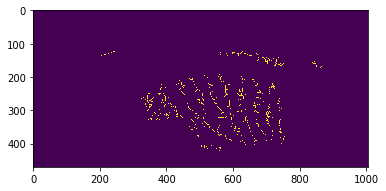

In [ ]:
from skimage.morphology import skeletonize
skeleton = skeletonize(color.rgb2gray(new>0))
plt.imshow(skeleton)

## Medida de longitud y anchura.

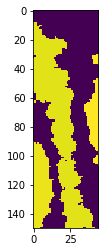

In [ ]:
#prueba = new[175:450, 300:800]
prueba = new[200:350, 570:615]
plt.imshow(prueba)
#plt.plot(props[0].coords[0], 'ro')
plt.show()

## Otra segmentación.

In [ ]:
from skimage import segmentation
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure


def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fafe275f2b0>)

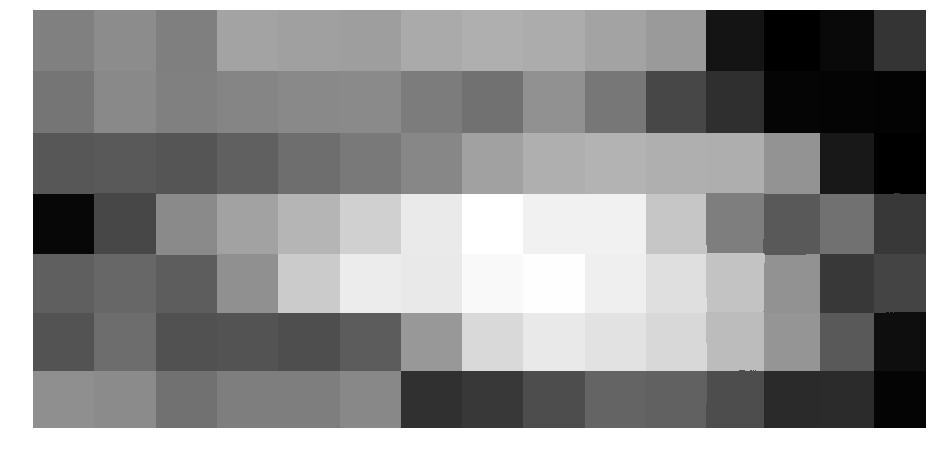

In [ ]:
astronaut_slic = segmentation.slic(img_sup)
image_show(color.label2rgb(astronaut_slic, img_sup, kind='avg'))

In [ ]:
chan_vese = seg.chan_vese(img_sup)

In [ ]:
A = np.array([[0,0,0,1,0,0],
     [0,0,2,2,1,0],
     [0,0,0,3,2,0],
     [0,0,1,1,2,0],
     [0,0,0,0,0,0]])
numpy.where(~A.any(axis=0))[0], numpy.where(~A.T.any(axis=0))[0]

(array([0, 1, 5]), array([4]))

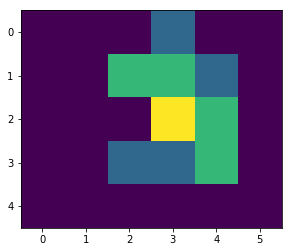

In [ ]:
plt.imshow(A)

In [ ]:
nocols=numpy.where(~A.any(axis=0))[0]
norows = numpy.where(~A.T.any(axis=0))[0]

A[~nocols]

IndexError: index -6 is out of bounds for axis 0 with size 5

In [ ]:
nocols

array([0, 1, 5])